## The following code is for deriving the value of the p operator (to higher powers) using natural variables

In [1]:
from pysces import *

#### For this example, we are calculating the following:

#### $$ \frac{d<p>}{dt} = -<V'> $$

_(Equation 2.2 in J. Chem. Phys. 137, 224115 (2012); doi: 10.1063/1.4770224)_


We can derive the above using the heisenberg equation of motion:

#### $$ i*\hbar*\frac{d<A>}{dt} = <[A, H]> $$

We first must define the hamiltonian and the heisenberg equation of motion, as shown below, named `ham` and `heom` respectively:

In [2]:
hbar = Symbol("hbar")

def ham(p, q):
    p, m, q, v = symbols("p m q v")
    v = Function("v")
    return Operator((lin_mom(q, 2))/(2*m)) + Operator(v(q))

#def heom(a):
#    return Operator(i*h_b*comm_1(Operator(a), Operator(ham(p, q)), None))

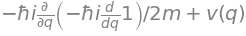

In [3]:
ham(p, q)

_Note: For this example, we do not use the `heom` function, although it is defined._

_Note: Oftentimes in the pysces code, a `1` is put as a place holder in a derivative. If this was left blank, an error message would occur._

By defining the functions as an `Operator`, we are able to choose where in the expression the function will be placed. Since we are computing the commutator, we also need an auxiliary function, defined by `aux` below using the predefined `Function` in the SymPy library. Here, we define the heisenberg equation of motion by `h1`.

In order to manipulate the expression, we must turn it into strings to perform the proper replacements. Here, we are calculating the p operator to the first power, however, that can be changed to a higher power.

In [4]:
aux = Operator(Function("f")(q))

h1 = expand(((Commutator(Operator(p),ham(p, q)).expand(commutator=True))*aux).doit())

print(h1)
# Below is the lin_mom function that describes the p operator (linear momentum operator) to the first power.
p1 = str(lin_mom(q, 1))
print(p1)

# Below we replace the `p` operator in the h1 equation with the correct linear momentum operator (defined above)
h1 = (str(simplify(h1)).replace("p", str(Operator(p1))))

print(h1)

p*-hbar*i*Derivative(-hbar*i*Derivative(1, q), q)/(2*m)*f(q) + p*v(q)*f(q) - -hbar*i*Derivative(-hbar*i*Derivative(1, q), q)/(2*m)*p*f(q) - v(q)*p*f(q)
-hbar*i*Derivative(1, q)
-0*-hbar*i*Derivative(1, q)*f(q) + -hbar*i*Derivative(1, q)*0*f(q) + -hbar*i*Derivative(1, q)*v(q)*f(q) - v(q)*-hbar*i*Derivative(1, q)*f(q)


Now, we have the string version of the heisenberg equation of motion. However, we still have the `1` values in the derivatives, which must be replaced for proper calculation. In order to do this, we must first find what to replace the `1` values with. This is done in the below cell, where we locate the start and ends points of the expression of interest to replace the `1`.

In [5]:
start_points = []
end_points = []

start = 0

# The below searches through the string to find the phrase of interest,
# By first finding the end of the derivative phrase, and then by finding the end of the auxiliary function
# The phrase of interest is found between the derivative phrase and the auxiliary function
while s != -1:
    s = h1.find("Derivative(1, q)", start)
    start = s + len(f"Derivative(1, q)")
    start_points.append(s)
    if s == -1:
        break
    
    e = h1.find("f(q)", start) + 4
    end_points.append(e)

The above code may add a value of `-1` to the lists as it finds the phrases. To delete the extra value and check the start and end points, the below function is used. The first start value goes with the first end value, and so on.

In [6]:
if start_points[-1] == -1:
    start_points.remove(start_points[-1])

print(start_points)
print(end_points)



[11, 43, 77, 119]
[32, 66, 103, 140]


The below code finds the position of all of the `1` placeholder values within the derivative function, appends it to a list, while also appending the phrase of interest (the `new_derivative_function`) to a separate list.

In [8]:
new_derivative_function = []
replace_spot = []

for i in range(len(start_points)):
    func = h1[start_points[i]:end_points[i]]
    func = start_points[i] + len(f"Derivative(1, {q})")
    func1 = h1.find("*", func, end_points[i])
        
    repl = h1[start_points[i]:end_points[i]].find("1") + start_points[i]
    replace_spot.append(repl)


    new_func = h1[func1:end_points[i]]
    new_derivative_function.append(new_func)

print(new_derivative_function)

['*f(q)', '*0*f(q)', '*v(q)*f(q)', '*f(q)']


Since there are multiple derivates and multiple phrases of interest, we need to cut the string into parts in order to ensure the correct phrases of interest replace the `1` placeholders. This is done in the cell below. Once this is completed, the string slices are recombined, and `sympify` is used to turn the string into a form that can be read by the SymPy library, and therefore compute the derivative.

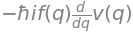

In [9]:
temp = h1.split(" ")
position_list = []
string_list = []
temp_list = []

for i in range(len(temp)):

    for r in range(1, len(new_derivative_function)):
        if temp[i].find(new_derivative_function[r]) != -1:
            temp[i] = temp[i].replace(new_derivative_function[r], "") 

    if temp[i].find("Derivative") == -1:
        continue
    
    else:
        position = temp[i].find("1,")
        if position != -1:
            position_list.append(position)
            temp_list.append(i)
    

TL = len(temp_list) - 1
nested_list = []
while TL > -1: 
    r = [temp_list[TL], position_list[TL]]
    nested_list.append(r) 
    TL -= 1 
    if TL == -1:
        break

nested_list.reverse()

for i in range(len(nested_list)):
    temp[nested_list[i][0]] = \
        temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], new_derivative_function[i][1:])

string = " ".join(temp)
s = sympify(string)

s1 = expand(s.doit())

#i = sqrt(-1)

s1

Here we can see the value of $ \frac{d}{dq}*v(q) $ which is the same as $<V>$ in the original equation that we had hoped to derive. Please note there is an extra factor of $ i\hbar $ which is still a concern (although can be divided by both sides to produce $ f(q) * (-<v>) $ which matches the original equation. The $ f(q) $ can also be removed, as it was the auxiliary function.

### Notes.

This is not yet complete. When I move to higher derivatives, it becomes harder to see the correct derivation. More insight into how the functions are derived by hand is needed to accurately improve the above course of action. In theory, the p operator can be computed to higher powers, thus increasing the accuracy as described by Akimov et. al, and may provide computational cost benefits.

There also exists code to calculate the q operator similarly to higher powers.